<a href="https://colab.research.google.com/github/andradec/ReconhecimentoFacial/blob/main/ReconhecimentoFacial_IAGenerativa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Bibliotecas gerais para manipulação de imagens e geração de graficos
import os
import cv2 as cv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#Bibliotecas especificas do modulo Keras utilizadas no desenvolvimento do projeto
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from sklearn.metrics import mean_absolute_error
from keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Dense

#Biblioteca utilizada para divisão da base de teste
from sklearn.model_selection import train_test_split



In [3]:
df = pd.read_csv("/content/drive/My Drive/archive (4)/faces.csv")
df_test = pd.read_csv("/content/drive/My Drive/MidJourney/anotacao/annotations.csv")

In [ ]:
df.head()

,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,490,320,687,664
1,00001044.jpg,2000,1333,791,119,1200,436
2,00001050.jpg,667,1000,304,155,407,331
3,00001736.jpg,626,417,147,14,519,303
4,00003121.jpg,626,418,462,60,599,166


In [ ]:
df_test.head()

,image_name,width,height,x0,y0,x1,y1
0,Jsan_Create_a_art_print_inspired_on_salvador_d...,1024,1024,233.62,59.32,806.14,802.51
1,Jsan_Create_a_art_print_inspired_on_salvador_d...,1024,1024,269.93,134.37,787.99,691.15
2,Jsan_Create_a_art_print_with_reference_of_most...,1024,1024,177.94,99.27,775.88,1022.80
3,Jsan_Create_a_art_print_with_reference_of_most...,1024,1024,271.15,10.91,841.24,712.94
4,Jsan_Create_a_art_print_with_reference_of_most...,1024,1024,407.92,16.96,1024.00,766.20


In [4]:
data = {}                                          # the image will be resized to 128x128 so here we are extracting the bbox coordinates
for i in df["image_name"]:                         # and we are rescaling it to 128x128 images
  if i not in data:
    data[i] = []
for idx, img_name in enumerate(df["image_name"]):
      width = df["width"][idx]
      height = df["height"][idx]
      x1 = df["x0"][idx]
      y1 = df["y0"][idx]
      x2 = df["x1"][idx]
      y2 = df["y1"][idx]

      new_x1 = int((x1/width)*128)
      new_y1 = int((y1/height)*128)
      new_x2 = int((x2/width)*128)
      new_y2 = int((y2/height)*128)

      data[img_name].append(new_x1)
      data[img_name].append(new_y1)
      data[img_name].append(new_x2)
      data[img_name].append(new_y2)

In [5]:
data_test = {}                                          # the image will be resized to 128x128 so here we are extracting the bbox coordinates
for i in df_test["image_name"]:                         # and we are rescaling it to 128x128 images
  if i not in data_test:
    data_test[i] = []
for idx, img_name in enumerate(df_test["image_name"]):
      width = df_test["width"][idx]
      height = df_test["height"][idx]
      x1 = df_test["x0"][idx]
      y1 = df_test["y0"][idx]
      x2 = df_test["x1"][idx]
      y2 = df_test["y1"][idx]

      new_x1 = int((x1/width)*128)
      new_y1 = int((y1/height)*128)
      new_x2 = int((x2/width)*128)
      new_y2 = int((y2/height)*128)

      data_test[img_name].append(new_x1)
      data_test[img_name].append(new_y1)
      data_test[img_name].append(new_x2)
      data_test[img_name].append(new_y2)

In [ ]:
print(df)

        image_name  width  height   x0   y0    x1   y1
0     00001722.jpg   1333    2000  490  320   687  664
1     00001044.jpg   2000    1333  791  119  1200  436
2     00001050.jpg    667    1000  304  155   407  331
3     00001736.jpg    626     417  147   14   519  303
4     00003121.jpg    626     418  462   60   599  166
...            ...    ...     ...  ...  ...   ...  ...
3345  00002232.jpg    620     349    4   36   186  158
3346  00002232.jpg    620     349  122  103   344  248
3347  00002232.jpg    620     349  258  118   541  303
3348  00002232.jpg    620     349  215   11   362  108
3349  00002232.jpg    620     349  330    1   487   81

[3350 rows x 7 columns]


In [ ]:
print(df_test)

                                           image_name  width  height      x0  \
0   Jsan_Create_a_art_print_inspired_on_salvador_d...   1024    1024  233.62   
1   Jsan_Create_a_art_print_inspired_on_salvador_d...   1024    1024  269.93   
2   Jsan_Create_a_art_print_with_reference_of_most...   1024    1024  177.94   
3   Jsan_Create_a_art_print_with_reference_of_most...   1024    1024  271.15   
4   Jsan_Create_a_art_print_with_reference_of_most...   1024    1024  407.92   
5   Jsan_Create_a_captivating_and_visually_stunnin...   1024    1024   88.37   
6   Jsan_Create_a_dynamic_and_thought-provoking_pi...   1024    1024  105.32   
7   Jsan_Create_a_dynamic_and_thought-provoking_pi...   1024    1024  341.35   
8   Jsan_Create_a_dynamic_and_thought-provoking_pi...   1024    1024  282.04   
9   Jsan_sleep_8101b301-42ce-46c6-940e-391203376b1...   1024    1024  130.74   
10  afkupuz_Dynamic_full_body_pose_style_of_Wlop_A...    896    1344  206.59   
11  aie_rico_A_scientist_looks_into_the_

In [ ]:
img_dir = os.listdir('/content/drive/My Drive/archive (4)/images')
images = []
for img_name in data.keys():
    for itr in img_dir:
      if img_name==itr:
        img_arr = cv.imread(os.path.join('/content/drive/My Drive/archive (4)/images', img_name), cv.IMREAD_GRAYSCALE)
        resized_img = cv.resize(img_arr, (128, 128))
        images.append(resized_img)

In [7]:
img_dir_test = os.listdir('/content/drive/My Drive/MidJourney')
images_test = []
for img_name in data_test.keys():
    for itr in img_dir_test:
      if img_name==itr:
        img_arr_test = cv.imread(os.path.join('/content/drive/My Drive/MidJourney', img_name), cv.IMREAD_GRAYSCALE)
        resized_img_test = cv.resize(img_arr_test, (128, 128))
        images_test.append(resized_img_test)

In [8]:
bbox = []
for boxes in data.keys():
  bbox.append(data[boxes])

In [9]:
bbox_test = []
for boxes in data_test.keys():
  bbox_test.append(data_test[boxes])

In [10]:
images = np.array(images)

In [11]:
images_test = np.array(images_test)

In [12]:
images = np.expand_dims(images, axis=3)

In [13]:
images_test = np.expand_dims(images_test, axis=3)

In [14]:
print(f"shape of images {images.shape}")

shape of images (2204, 128, 128, 1)


In [15]:
print(f"shape of images test {images_test.shape}")

shape of images test (50, 128, 128, 1)


In [16]:
max_bbox = 0
for i in range(len(bbox)):
  max_bbox = max(max_bbox, len(bbox[i]))
print(f"the max faces in the image are {int(max_bbox/4)}")

the max faces in the image are 12


In [17]:
max_bbox_test = 0
for i in range(len(bbox_test)):
  max_bbox_test = max(max_bbox_test, len(bbox_test[i]))
print(f"the max faces in the image are {int(max_bbox_test/4)}")

the max faces in the image are 2


In [18]:
for i in range(len(bbox)):
  if int(max_bbox) - len(bbox[i])!=0:
    for j in range(int(max_bbox) - len(bbox[i])):
      bbox[i].append(0)

In [19]:
for i in range(len(bbox_test)):
  if int(max_bbox_test) - len(bbox_test[i])!=0:
    for j in range(int(max_bbox_test) - len(bbox_test[i])):
      bbox_test[i].append(0)

In [20]:
bbox = np.array(bbox)

In [21]:
bbox_test = np.array(bbox_test)

In [22]:
print(f"shape of bbox {bbox.shape}")

shape of bbox (2204, 48)


In [23]:
print(f"shape of bbox test {bbox_test.shape}")

shape of bbox test (50, 8)


In [24]:
images = images/255
bbox = bbox/128

In [25]:
images_test = images_test/255
bbox_test = bbox_test/128

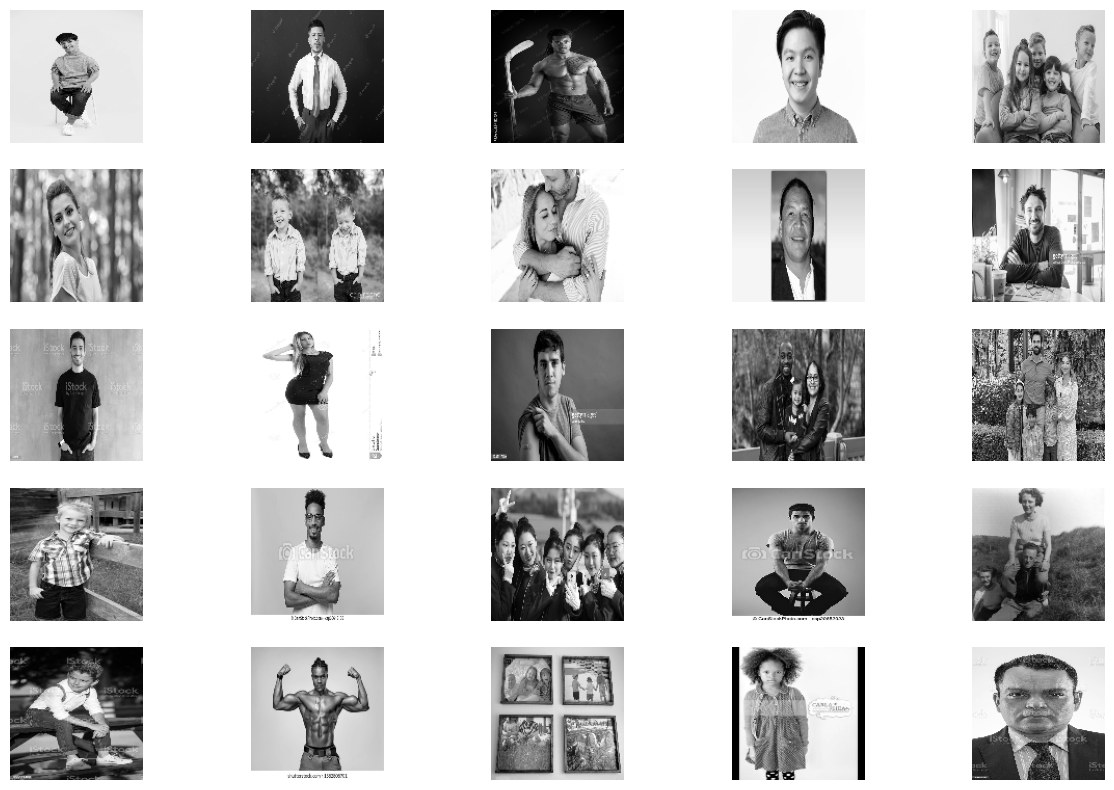

In [26]:
plt.figure(figsize=(15,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(images[i], cmap='gray')
  plt.axis("off")

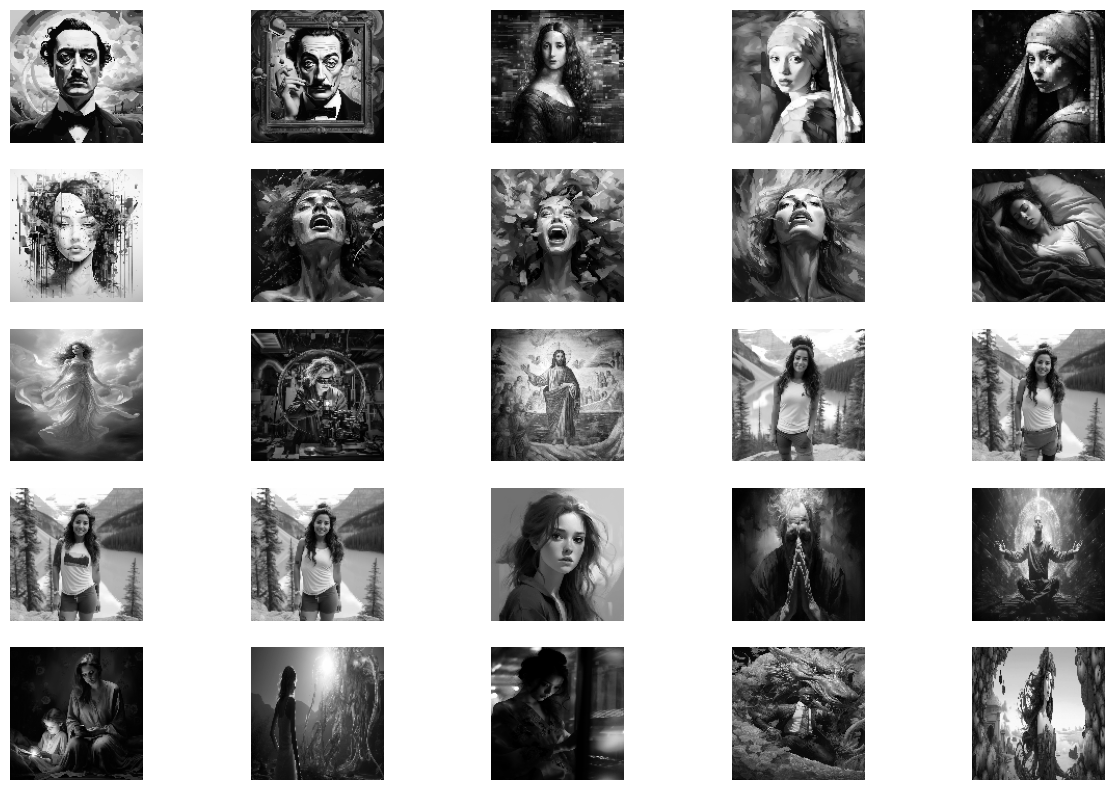

In [27]:
plt.figure(figsize=(15,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(images_test[i], cmap='gray')
  plt.axis("off")

In [28]:
x_train, x_test, y_train, y_test = train_test_split(images, bbox, test_size=0.1, random_state=22)
x_train1, x_test1, y_train1, y_test1 =  train_test_split(images, bbox, test_size=0.0227, random_state=22)

In [29]:
conjunto_val = 50
indice_inicial = 0
conjunto_imagens = y_test1[indice_inicial:indice_inicial + conjunto_val]


In [30]:
model1 = Sequential()

model1.add(Conv2D(32, (3,3), input_shape=(128,128,1), padding="same", activation="leaky_relu"))
model1.add(MaxPool2D(2,2))
model1.add(Conv2D(64, (3,3), padding="same", activation="leaky_relu"))
model1.add(MaxPool2D(2,2))
model1.add(Conv2D(128, (3,3), padding="same", activation="leaky_relu"))
model1.add(MaxPool2D(2,2))
model1.add(Conv2D(256, (3,3), padding="same", activation="leaky_relu"))
model1.add(MaxPool2D(2,2))
model1.add(GlobalAveragePooling2D())
model1.add(Dense(256, activation="leaky_relu"))
model1.add(Dense(64, activation="leaky_relu"))
model1.add(Dense(48, activation="sigmoid"))

In [31]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 128)       0

In [32]:
class CustomCallbacks(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    prediction = model1.predict(x_test[0].reshape(1, 128, 128, 1))
    fig, ax = plt.subplots(1)
    ax.imshow(x_test[0])
    x1 = int(prediction[0][0]*128)
    y1 = int(prediction[0][1]*128)
    x2 = int(prediction[0][2]*128)
    y2 = int(prediction[0][3]*128)
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1,edgecolor='r', facecolor="none")
    ax.add_patch(rect)
    plt.show()

In [33]:
model1.compile(optimizer = "adam", loss="binary_crossentropy", metrics=['accuracy', keras.metrics.Precision(name='precision_metric')])

In [ ]:
history1 = model1.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, callbacks=[CustomCallbacks()])

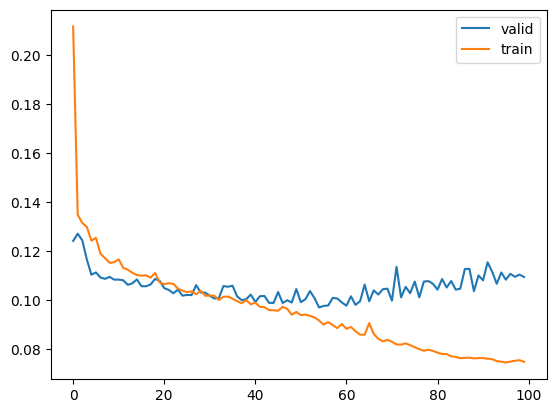

In [35]:
plt.plot(history1.history["val_loss"])
plt.plot(history1.history["loss"])
plt.legend(["valid", "train"])
plt.show()

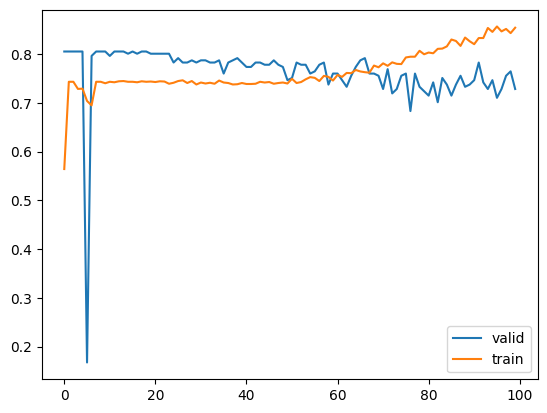

In [36]:
plt.plot(history1.history["val_accuracy"])
plt.plot(history1.history["accuracy"])
plt.legend(["valid", "train"])
plt.show()

In [37]:
y_pred = model1.predict(x_test)
x_test.shape

7/7 [==============================] - 0s 7ms/step


(221, 128, 128, 1)

In [38]:
y_pred1 = model1.predict(images_test)
images_test.shape

2/2 [==============================] - 0s 179ms/step


(50, 128, 128, 1)

In [39]:
print(f"mean absolute error is {mean_absolute_error(y_pred, y_test)}")
conjunto_imagens.shape

mean absolute error is 0.024224101963938427


(50, 48)

In [40]:
print(f"mean absolute error is {mean_absolute_error(y_pred1, conjunto_imagens)}")

mean absolute error is 0.0319397505679944


In [41]:
model2 = Sequential()

model2.add(Conv2D(32, (3,3), input_shape=(128,128,1), activation="relu"))
model2.add(Dropout(0.1))
model2.add(MaxPool2D(2,2))
model2.add(BatchNormalization())
model2.add(Conv2D(64, (3,3), activation="relu"))
model2.add(Dropout(0.1))
model2.add(MaxPool2D(2,2))
model2.add(BatchNormalization())
model2.add(Conv2D(128, (3,3), activation="relu"))
model2.add(Dropout(0.2))
model2.add(MaxPool2D(2,2))
model2.add(BatchNormalization())
model2.add(Conv2D(256, (3,3), activation="relu"))
model2.add(Dropout(0.3))
model2.add(MaxPool2D(2,2))
model2.add(BatchNormalization())
model2.add(GlobalAveragePooling2D())
model2.add(Dense(256, activation="leaky_relu"))
model2.add(Dense(48, activation="sigmoid"))

In [42]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 dropout (Dropout)           (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 63, 63, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 61, 61, 64)       

In [43]:
class CustomCallbacks2(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    prediction = model2.predict(x_test[0].reshape(1, 128, 128, 1))
    fig, ax = plt.subplots(1)
    ax.imshow(x_test[0])
    x1 = int(prediction[0][0]*128)
    y1 = int(prediction[0][1]*128)
    x2 = int(prediction[0][2]*128)
    y2 = int(prediction[0][3]*128)
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1,edgecolor='r', facecolor="none")
    ax.add_patch(rect)
    plt.show()

In [44]:
model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy', keras.metrics.Precision(name='precision_metric')])


In [ ]:
history2 = model2.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=8, epochs=100, callbacks=[CustomCallbacks2()])

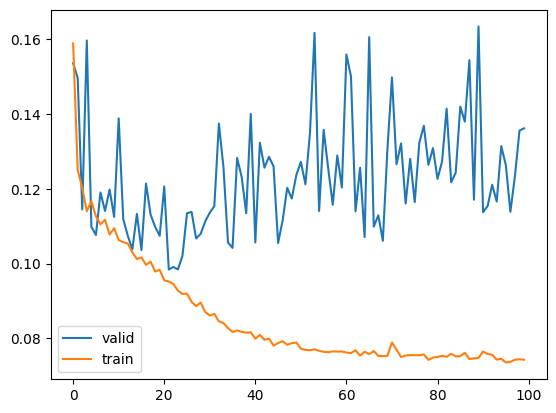

In [46]:
plt.plot(history2.history["val_loss"])
plt.plot(history2.history["loss"])
plt.legend(["valid", "train"])
plt.show()

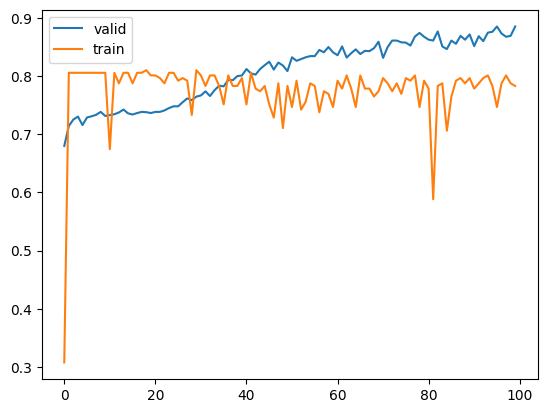

In [47]:
plt.plot(history2.history["accuracy"])
plt.plot(history2.history["val_accuracy"])
plt.legend(["valid", "train"])
plt.show()

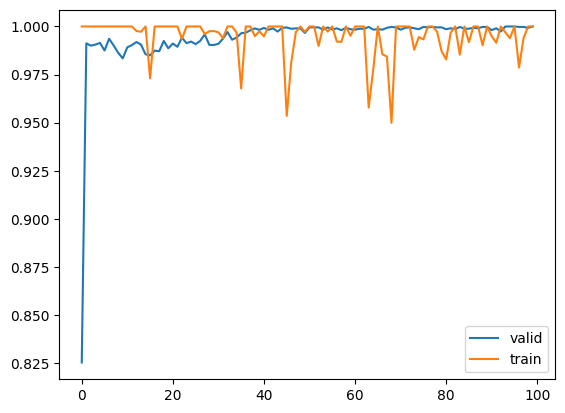

In [48]:
plt.plot(history2.history["precision_metric"])
plt.plot(history2.history["val_precision_metric"])
plt.legend(["valid", "train"])
plt.show()

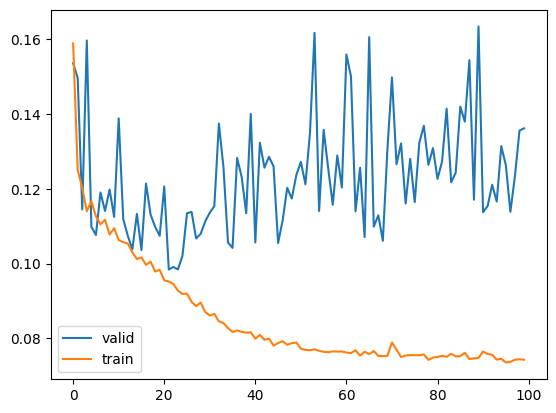

In [49]:
plt.plot(history2.history["val_loss"])
plt.plot(history2.history["loss"])
plt.legend(["valid", "train"])
plt.show()

In [50]:
y_pred2 = model2.predict(images_test)

2/2 [==============================] - 0s 138ms/step


In [51]:
print(f"mean absolute error is {mean_absolute_error(y_pred2, conjunto_imagens)}")

mean absolute error is 0.029982456534691584


In [82]:
resultado2 = model2.evaluate(images_test, conjunto_imagens)
print("Perda (Loss):", resultado2[0])
print("Acurácia:", resultado2[1])

2/2 [==============================] - 0s 11ms/step - loss: 0.2485 - accuracy: 0.8600 - precision_metric: 1.0000
Perda (Loss): 0.24850036203861237
Acurácia: 0.8600000143051147


In [83]:
resultado1 = model1.evaluate(images_test, conjunto_imagens)
print("Perda (Loss):", resultado1[0])
print("Acurácia:", resultado1[1])

2/2 [==============================] - 0s 13ms/step - loss: 0.2719 - accuracy: 0.7800 - precision_metric: 1.0000
Perda (Loss): 0.2719276249408722
Acurácia: 0.7799999713897705


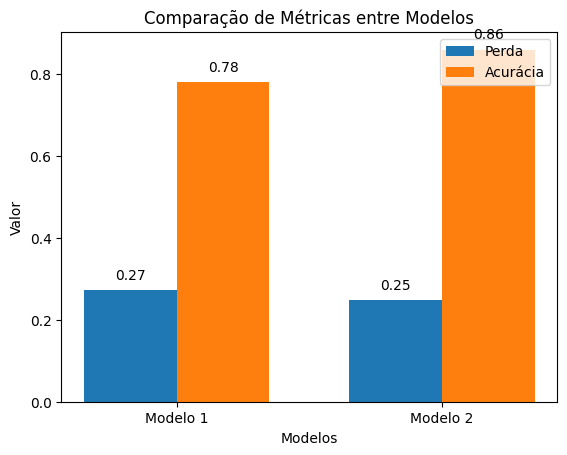

In [90]:
modelos = ['Modelo 1', 'Modelo 2']
perda = [resultado1[0], resultado2[0]]
acuracia = [resultado1[1], resultado2[1]]
largura_barra = 0.35
indices = range(len(modelos))
fig, ax = plt.subplots()
barra_perda = ax.bar(indices, perda, largura_barra, label='Perda')
barra_acuracia = ax.bar([p + largura_barra for p in indices], acuracia, largura_barra, label='Acurácia')
ax.set_xlabel('Modelos')
ax.set_ylabel('Valor')
ax.set_title('Comparação de Métricas entre Modelos')
ax.set_xticks([p + largura_barra / 2 for p in indices])
ax.set_xticklabels(modelos)
ax.legend()
for i in range(len(perda)):
    ax.text(i, perda[i] + 0.02, round(perda[i], 2), ha='center', va='bottom')
    ax.text(i + largura_barra, acuracia[i] + 0.02, round(acuracia[i], 2), ha='center', va='bottom')
plt.show()


In [53]:
def model1_predictions(img_number):
  model1_prediction = model1.predict(images_test[img_number].reshape(1, 128, 128, 1))
  model1_prediction = model1_prediction[0]
  img = images_test[img_number]

  count = 0
  bbox1 = []
  for i in model1_prediction:
    bbox1.append(i)
    count+=1
    if count==4:
      count = 0
      plt.subplot(1,2,1)
      plt.imshow(img)
      x1 = int(bbox1[0]*128)
      y1 = int(bbox1[1]*128)
      x2 = int(bbox1[2]*128)
      y2 = int(bbox1[3]*128)
      plt.gca().add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1,edgecolor='r', facecolor="none"))
      bbox1 = []
  plt.show()

1/1 [==============================] - 0s 19ms/step


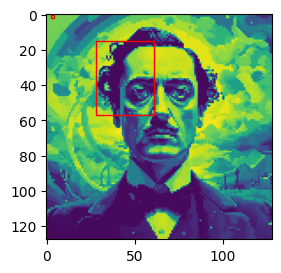

In [54]:
model1_predictions(0)

In [56]:
def model2_predictions(img_number):
  model2_prediction = model2.predict(images_test[img_number].reshape(1, 128, 128, 1))
  model2_prediction = model2_prediction[0]
  img = images_test[img_number]

  count = 0
  bbox1 = []
  for i in model2_prediction:
    bbox1.append(i)
    count+=1
    if count==4:
      count = 0
      plt.subplot(1,2,1)
      plt.imshow(img)
      x1 = int(bbox1[0]*128)
      y1 = int(bbox1[1]*128)
      x2 = int(bbox1[2]*128)
      y2 = int(bbox1[3]*128)
      plt.gca().add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1,edgecolor='r', facecolor="none"))
      bbox1 = []
  plt.show()

1/1 [==============================] - 0s 18ms/step


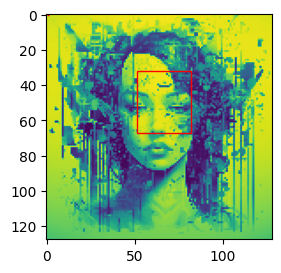

In [57]:
model2_predictions(5)